In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin

sys.path.append("/work/gallim/SIMStudies/wipfs/preproce/electrons")
from preprocessing import saturation

class MaskMixin:
    """Mixin class for masking values in a numpy array"""

    def __init__(self, mask_lower_bound=None, mask_upper_bound=None):
        self.mask_lower_bound = mask_lower_bound
        self.mask_upper_bound = mask_upper_bound

    def apply_mask(self, arr):
        mask = np.ones(arr.shape[0], dtype=bool)
        if self.mask_lower_bound is not None:
            mask = mask & (arr >= np.asarray(self.mask_lower_bound)).reshape(-1)
        if self.mask_upper_bound is not None:
            mask = mask & (arr <= np.asarray(self.mask_upper_bound)).reshape(-1)
        return mask

class Smearer(TransformerMixin, BaseEstimator, MaskMixin):
    def __init__(self, kind, mask_lower_bound=None, mask_upper_bound=None):
        if kind not in ["gaus", "uniform"]:
            raise ValueError
        self.kind = kind
        self.mask_lower_bound = mask_lower_bound
        self.mask_upper_bound = mask_upper_bound

    def get_half_distances(self, arr):
        diffs = np.diff(arr)
        half_diffs = diffs / 2
        result = np.concatenate(
            (
                [arr[0] - half_diffs[0]],
                arr[:-1] + half_diffs,
                [arr[-1] + half_diffs[-1]],
            )
        )
        return result

    def count_occurrences(self, arr):
        unique_values = np.unique(arr).astype("int64")
        counts = np.bincount(arr.astype("int64")[:, 0])
        dct = dict(zip(unique_values, counts[unique_values]))
        # order by key
        dct = dict(sorted(dct.items()))
        return dct

    def find_closest_numbers(self, sample, numbers):
        closest_indices = np.argmin(
            np.abs(sample[:, 0] - numbers[:, np.newaxis]), axis=0
        )
        return numbers[closest_indices]

    def fit(self, X, y=None):
        self.occurrences = self.count_occurrences(X)
        self.values = np.array(list(self.occurrences.keys()))
        self.half_distances = self.get_half_distances(
            self.values
        )  # one more item wrt occurrances, values and half_widths
        self.half_widths = np.array(
            [
                np.abs(i - j)
                for i, j in zip(self.half_distances[:-1], self.half_distances[1:])
            ]
        )

        return self

    def transform(self, X, y=None):
        self.mask = self.apply_mask(X).reshape(X.shape)
        
        new_sub_arrs = []

        for idx, (number, occ) in enumerate(self.occurrences.items()):
            if self.kind == "uniform":
                smear = np.random.uniform(
                    low=self.half_distances[idx],
                    high=self.half_distances[idx + 1],
                    size=occ,
                )
            elif self.kind == "gaus":
                scale = self.half_widths[idx] / 8
                smear = np.random.normal(loc=number, scale=scale, size=occ)

            new_sub_arrs.append(smear)

        new_sub_arrs = np.concatenate(new_sub_arrs).reshape(X.shape)
        new_sub_arrs = np.sort(new_sub_arrs, axis=0)
        order = np.argsort(np.argsort(X, axis=0), axis=0).reshape(-1)
        new_sub_arrs = new_sub_arrs[order].reshape(X.shape)

        # applying smear for masked values and retaining original for others
        X_transformed = np.where(self.mask, new_sub_arrs, X)

        return X_transformed

    def inverse_transform(self, X, y=None):
        self.mask = self.apply_mask(X).reshape(X.shape)
        return np.where(
            self.mask,
            self.find_closest_numbers(X, self.values).reshape(-1, 1),
            X,
        )

class Displacer(TransformerMixin, BaseEstimator, MaskMixin):
    """Move the minimum to where_to_displace"""

    def __init__(
        self, mask_lower_bound=None, mask_upper_bound=None, where_to_displace=None
    ):
        self.mask_lower_bound = mask_lower_bound
        self.mask_upper_bound = mask_upper_bound
        self.where_to_displace = where_to_displace

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        self.mask = self.apply_mask(X).reshape(X.shape)
        self.minimum = np.min(X[self.mask])
        X_transformed = np.where(
            self.mask, X - self.minimum + self.where_to_displace, X
        )
        return X_transformed

    def inverse_transform(self, X, y=None):
        X = X.copy()
        self.mask = self.apply_mask(X).reshape(X.shape)
        return np.where(
            self.mask, X + self.minimum - self.where_to_displace, X
        )

In [3]:
input_dir = "/work/gallim/SIMStudies/FlashSimStudies/preprocessing/extracted_photons"
files = [f"{input_dir}/{f}" for f in os.listdir(input_dir)][:10]

df = dd.read_parquet(files).compute()

In [4]:
df.columns

Index(['GenPho_pt', 'GenPho_eta', 'GenPho_phi', 'GenPho_status',
       'GenPho_statusFlags', 'RecoPho_pt', 'RecoPho_eta', 'RecoPho_phi',
       'RecoPho_mass', 'RecoPho_r9', 'RecoPho_sieie', 'RecoPho_eCorr',
       'RecoPho_energyErr', 'RecoPho_hoe', 'RecoPho_mvaID',
       'RecoPho_pfRelIso03_all', 'RecoPho_pfRelIso03_chg',
       'RecoPho_esEffSigmaRR', 'RecoPho_esEnergyOverRawE', 'RecoPho_etaWidth',
       'RecoPho_phiWidth', 'RecoPho_pfChargedIsoPFPV',
       'RecoPho_pfChargedIsoWorstVtx', 'RecoPho_pfPhoIso03', 'RecoPho_s4',
       'RecoPho_sieip', 'RecoPho_trkSumPtHollowConeDR03', 'RecoPho_x_calo',
       'RecoPho_y_calo', 'RecoPho_z_calo', 'GenPhoGenEle_deltar',
       'GenPhoGenEle_deltaphi', 'GenPhoGenEle_deltaeta',
       'GenPhoGenEle_ptratio', 'GenPhoGenJet_deltar', 'GenPhoGenJet_deltaphi',
       'GenPhoGenJet_deltaeta', 'GenPhoGenJet_ptratio', 'RecoPhoGenPho_deltar',
       'RecoPhoGenPho_deltaphi', 'RecoPhoGenPho_deltaeta',
       'RecoPhoGenPho_ptratio', 'ClosestGenJet

0.0 1.5976562


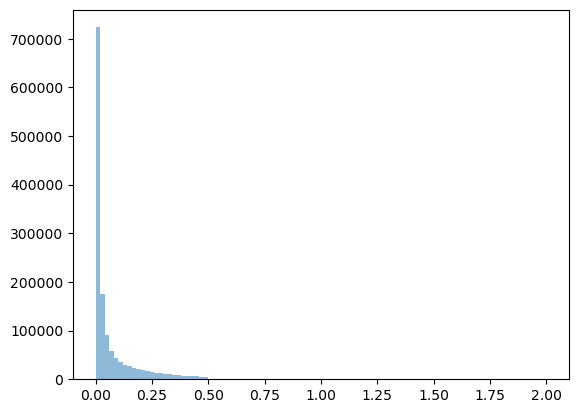

In [7]:
orig_rng = (0, 2)
var = df['RecoPho_hoe'].values
plt.hist(var, bins=100, range=orig_rng, alpha=0.5);
print(np.min(var), np.max(var))

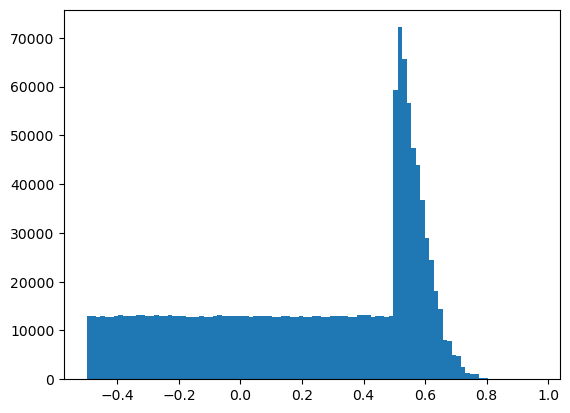

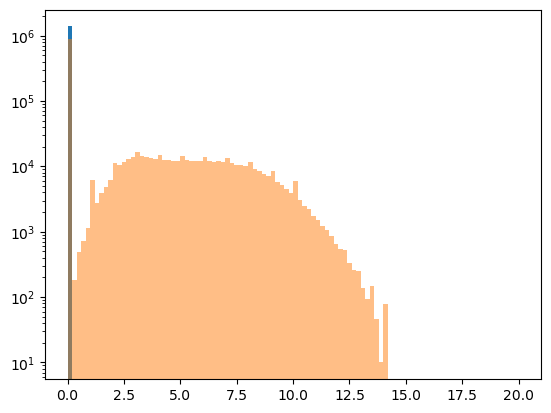

In [44]:
        
pipe = Pipeline(
    [
        ('qt', QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)),
        ('scaler', MinMaxScaler((0, 1))),
        ('displacer', Displacer(mask_lower_bound=0.5, where_to_displace=1)),
        ('smearer', Smearer('uniform', mask_upper_bound=0.5)),
        ('displacer_2', Displacer(mask_lower_bound=1, where_to_displace=0.5)),
        #("iso_transform", IsoTransformerLNorm()),
        #("standard", StandardScaler()),
    ]
)
orig_rng = (0, 20)
var = df['RecoPho_esEffSigmaRR'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=100);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.yscale('log')
plt.hist(old_var, bins=100, range=orig_rng);
plt.hist(var, bins=100, range=orig_rng, alpha=0.5);

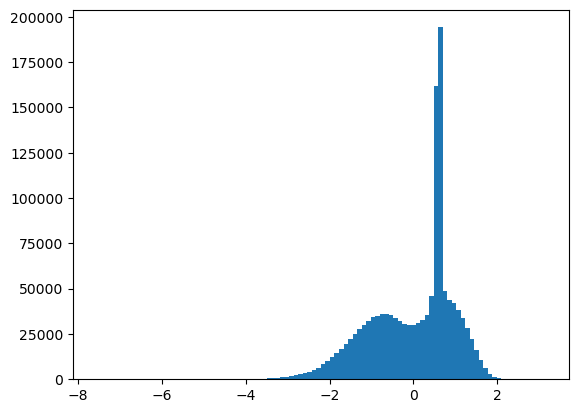

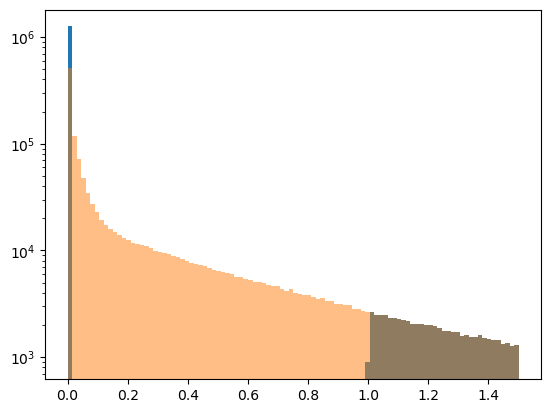

In [6]:
class IsoTransformerLNorm(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        zero_indices = np.where(X <= 0)[0]
        nonzero_indices = np.where(X > 0)[0]
        # replace 0s with values sampled from triangular distribution
        X[zero_indices] = -np.random.lognormal(mean=0.0001, sigma=0.1, size=len(zero_indices)).reshape(-1, 1)
        # shift the rest
        X[nonzero_indices] = np.log(X[nonzero_indices])
        return X
        
    def inverse_transform(self, X, y=None):
        X = X.copy()
        zero_indices = np.where(X <= 0)[0]
        nonzero_indices = np.where(X > 0)[0]
        # expm1 the rest
        X[nonzero_indices] = np.exp(X[nonzero_indices])
        # replace values less than 0 with 0
        X[zero_indices] = 0.
        return X

class IsoTransformerBC(TransformerMixin, BaseEstimator):
    """
    Transform the isolation variables with a box-cox transformation for values > 0 and a normal distribution for values <= 0.
    """
    #def __init__(self, loc=0., scale=0.1):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        non_zero_indices = np.where(X > 0)[0]
        x_non_zero = X[non_zero_indices]
        self.bc = PowerTransformer(method="box-cox").fit(x_non_zero.reshape(-1, 1))
        x_non_zero_bc = self.bc.transform(x_non_zero.reshape(-1, 1))
        self.min_bc = np.min(x_non_zero_bc)
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        zero_indices = np.where(X <= 0)[0]
        nonzero_indices = np.where(X > 0)[0]
        # replace 0s with values sampled from gaussian
        #X[zero_indices] = np.random.normal(loc=self.loc, scale=self.scale, size=len(zero_indices)).reshape(-1, 1)
        X[zero_indices] = -np.random.lognormal(mean=0.0001, sigma=0.1, size=len(zero_indices)).reshape(-1, 1)
        # shift the rest wiht boxcox
        X[nonzero_indices] = self.bc.transform(X[nonzero_indices])
        # now set the max of lognormal to 0 and the min of boxcox to 0
        X[zero_indices] -= np.max(X[zero_indices])
        X[nonzero_indices] -= self.min_bc
        return X
        
    def inverse_transform(self, X, y=None):
        X = X.copy()
        zero_indices = np.where(X <= 0)[0]
        nonzero_indices = np.where(X > 0)[0]
        # transform back the boxcox
        X[nonzero_indices] += self.min_bc
        X[nonzero_indices] = self.bc.inverse_transform(X[nonzero_indices])
        # replace values less than 0 with 0
        X[zero_indices] = 0.
        return X

pipe = Pipeline(
    [
        #('add', FunctionTransformer(lambda x: x + 1e-3, inverse_func=lambda x: x - 1e-3)),
        #('box-cox', PowerTransformer(method='box-cox', standardize=False)),
        #('scaler', MinMaxScaler((0, 1))),
        #('displacer', Displacer(mask_lower_bound=0.01, where_to_displace=1)),
        #('smearer', Smearer('uniform', mask_upper_bound=1.0)),
        #("sampler", IsoTransformerBC(loc=-1, scale=0.5)),
        #("iso_transform", IsoTransformerLNorm()),
        ("sampler", IsoTransformerBC()),
        ("standard", StandardScaler()),
    ]
)
orig_rng = (0, 1.5)
var = df['RecoPho_pfRelIso03_all'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=100);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.yscale('log')
plt.hist(old_var, bins=100, range=orig_rng);
plt.hist(var, bins=100, range=orig_rng, alpha=0.5);

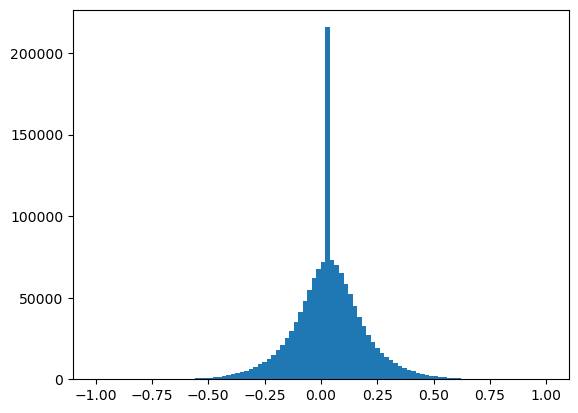

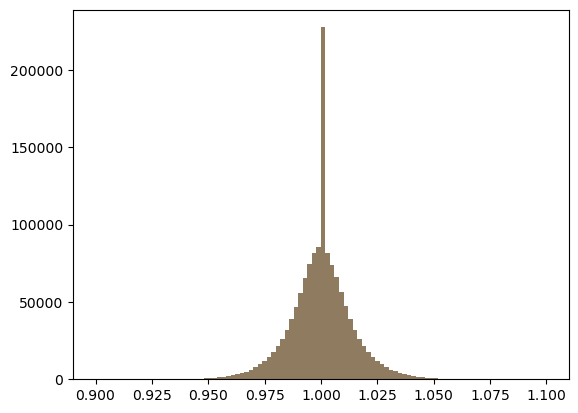

In [33]:
pipe = Pipeline(
    [
        #('box-cox', PowerTransformer(method='box-cox', standardize=False)),
        #('qt', QuantileTransformer(n_quantiles=10, output_distribution='uniform', random_state=0)),
        #('log', FunctionTransformer(lambda x: np.log(x), inverse_func=lambda x: np.exp(x))),
        #('box-cox', PowerTransformer(method='box-cox', standardize=True)),
        ('scaler', MinMaxScaler((-1, 1))),
        #('smearer', Smearer('gaus', mask_lower_bound=None, mask_upper_bound=None)),
    ]
)
orig_rng = (0.9, 1.1)
var = df['RecoPho_eCorr'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=100);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(old_var, bins=100, range=orig_rng);
plt.hist(var, bins=100, range=orig_rng, alpha=0.5);

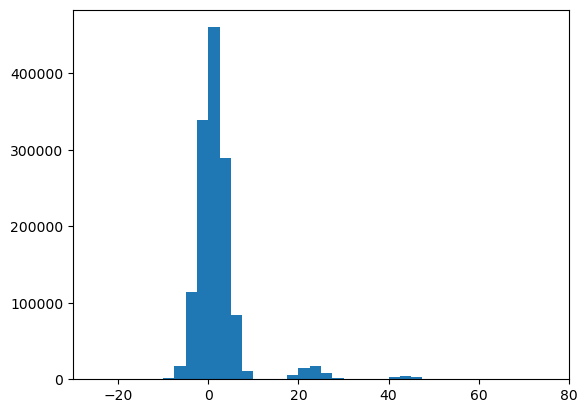

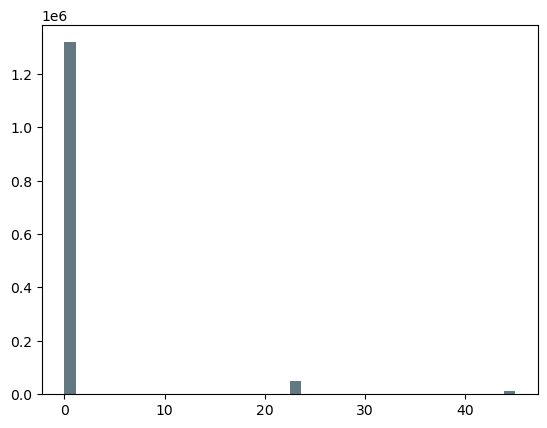

In [5]:
pipe = Pipeline(
    [
        ('smearer', Smearer('gaus')),
        #('scaler', MinMaxScaler((-1, 1)))
    ]
)

orig_rng = (0, 45)
var = df['GenPho_status'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40, range=(-25, 75));
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

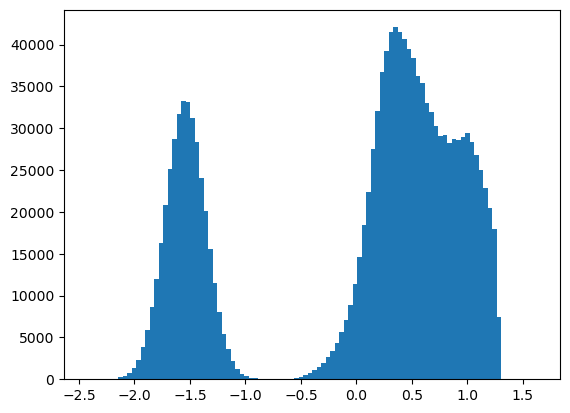

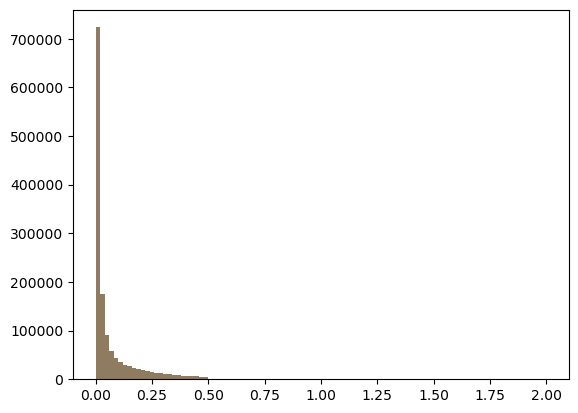

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class IsoTransformerBC(TransformerMixin, BaseEstimator):
    """
    Transform the isolation variables with a box-cox transformation for values > 0 and a normal distribution for values <= 0.
    """
    def __init__(self, loc=0., scale=0.1):
        self.loc = loc
        self.scale = scale
    
    def fit(self, X, y=None):
        non_zero_indices = np.where(X > 0)[0]
        x_non_zero = X[non_zero_indices]
        self.bc = PowerTransformer(method="box-cox").fit(x_non_zero.reshape(-1, 1))
        x_non_zero_bc = self.bc.transform(x_non_zero.reshape(-1, 1))
        self.min_bc = np.min(x_non_zero_bc)
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        zero_indices = np.where(X <= 0)[0]
        nonzero_indices = np.where(X > 0)[0]
        # replace 0s with values sampled from gaussian
        X[zero_indices] = np.random.normal(loc=self.loc, scale=self.scale, size=len(zero_indices)).reshape(-1, 1)
        # shift the rest wiht boxcox
        X[nonzero_indices] = self.bc.transform(X[nonzero_indices])
        # now set the max of lognormal to 0 and the min of boxcox to 0
        X[zero_indices] -= np.max(X[zero_indices])
        X[nonzero_indices] -= self.min_bc
        return X
        
    def inverse_transform(self, X, y=None):
        X = X.copy()
        zero_indices = np.where(X <= 0)[0]
        nonzero_indices = np.where(X > 0)[0]
        # transform back the boxcox
        X[nonzero_indices] += self.min_bc
        X[nonzero_indices] = self.bc.inverse_transform(X[nonzero_indices])
        # replace values less than 0 with 0
        X[zero_indices] = 0.
        return X

pipe = Pipeline(
    [
        #('scaler', MinMaxScaler((0.1, 5))),
        #('log', FunctionTransformer(lambda x: np.log(x + 1e-3), inverse_func=lambda x: np.exp(x) - 1e-3)),
        #('scaler2', MinMaxScaler((0, 10))),
        #('displacer', Displacer(mask_lower_bound=0.1, where_to_displace=1)),
        #('smearer', Smearer('uniform', mask_upper_bound=1.0)),
        #('displacer2', Displacer(mask_lower_bound=1, where_to_displace=0.5)),
        #('scaler3', MinMaxScaler((-1., 1.))),

        ("iso_transformer", IsoTransformerBC(loc=-1, scale=0.5)),
        ("standard", StandardScaler()),
    ]
)

orig_rng = (0, 2)
var = df['RecoPho_hoe'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=100);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(old_var, bins=100, range=orig_rng);
plt.hist(var, bins=100, range=orig_rng, alpha=0.5);

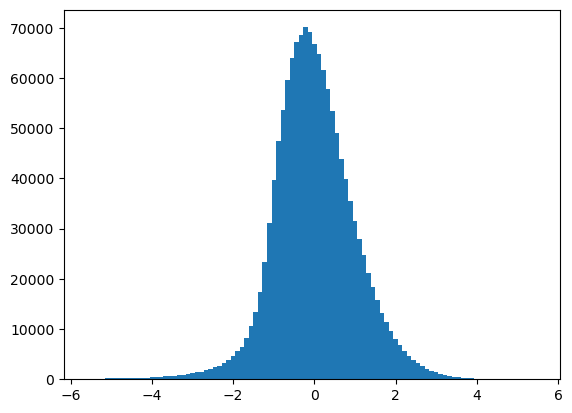

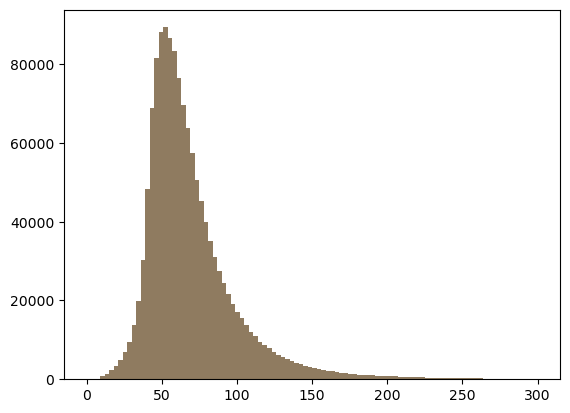

In [5]:
pipe = Pipeline(
        [
            #(
            #    "log_trans",
            #    FunctionTransformer(
            #        lambda x: np.log1p(x * 0.01),
            #        inverse_func=lambda x: np.expm1(x) / 0.01,
            #    ),
            #),
            #("scaler", MinMaxScaler((0, 1))),
            ("box-cox", PowerTransformer(method="box-cox")),
        ]
    )
orig_rng = (0, 300)
var = df['ClosestGenJet_pt'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=100);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(old_var, bins=100, range=orig_rng);
plt.hist(var, bins=100, range=orig_rng, alpha=0.5);

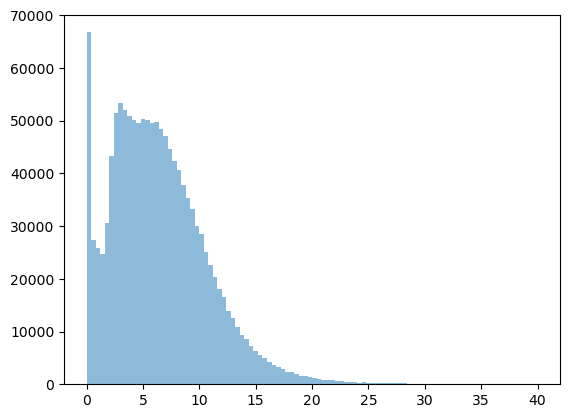

In [10]:
orig_rng = (0, 40)
var = df['ClosestGenJet_mass'].values
plt.hist(var, bins=100, range=orig_rng, alpha=0.5);

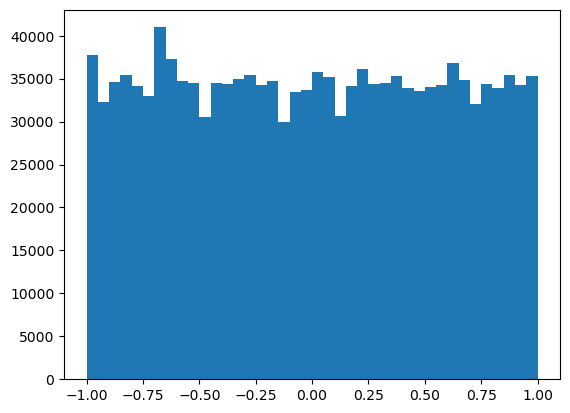

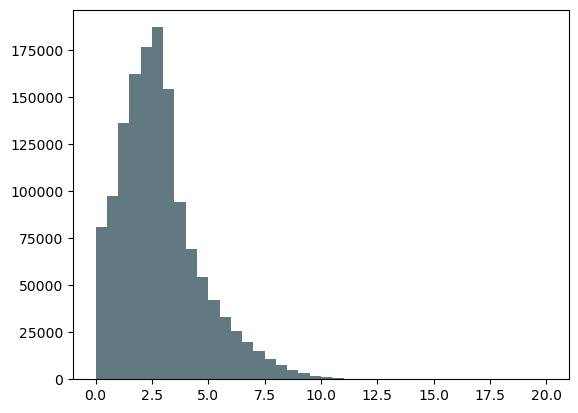

In [62]:
pipe = Pipeline(
    [
        #('log_trans', FunctionTransformer(lambda x: np.log1p(x), inverse_func=lambda x: np.expm1(x))),
        #('log_trans', FunctionTransformer(lambda x: np.log1p(x/5), inverse_func=lambda x: np.expm1(x)*5)),
        ('qt', QuantileTransformer()),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

orig_rng = (0, 20)
var = df['GenPhoGenEle_deltar'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

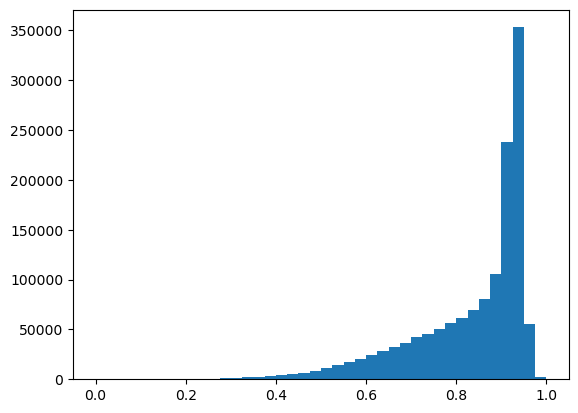

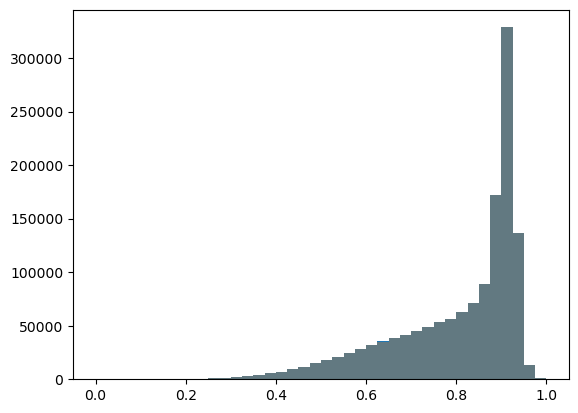

In [10]:
pipe = Pipeline(
    [
        ('log_trans', FunctionTransformer(lambda x: np.log1p(x), inverse_func=lambda x: np.expm1(x))),
        ('scaler', MinMaxScaler((0, 1)))
    ]
)

orig_rng = (0, 1)
var = df['RecoPho_s4'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

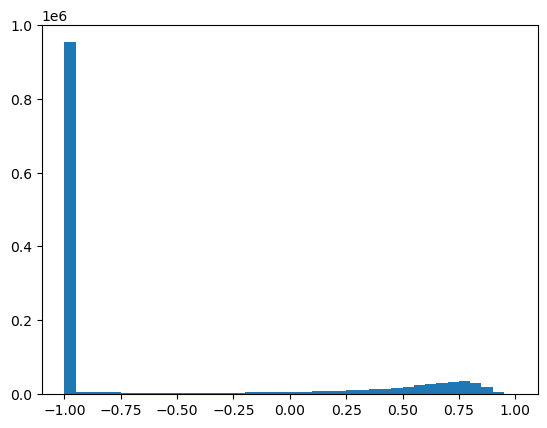

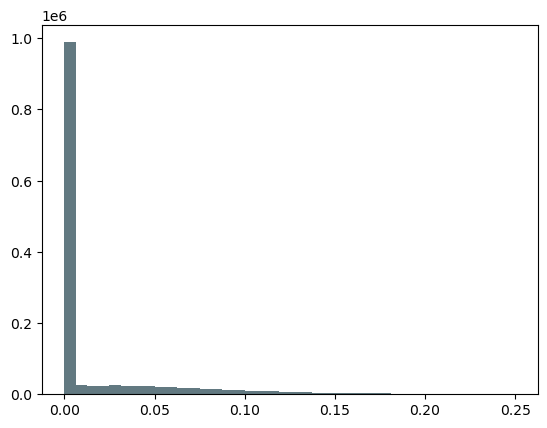

In [17]:
pipe = Pipeline(
    [
        #('log_trans', FunctionTransformer(lambda x: np.log1p(x), inverse_func=lambda x: np.expm1(x))),
        ('arctan_trans', FunctionTransformer(lambda x: np.arctan(x*50), inverse_func=lambda x: (np.tan(x))/50)),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

orig_rng = (0, 0.25)
var = df['RecoPho_esEnergyOverRawE'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

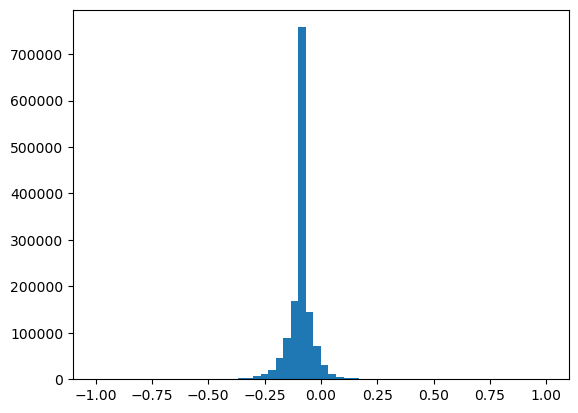

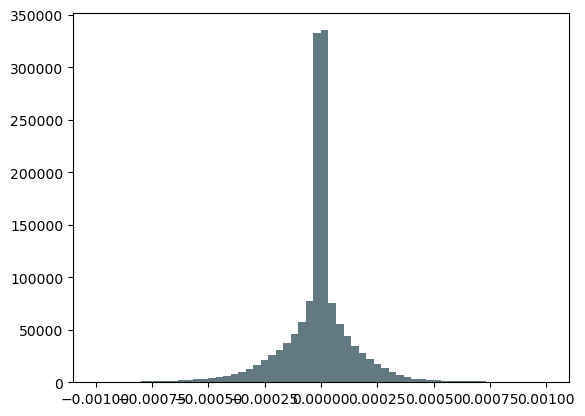

In [38]:
from sklearn.preprocessing import PowerTransformer

pipe = Pipeline(
    [
        #('box-cox', PowerTransformer()),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

orig_rng = (-0.001, 0.001)
var = df['RecoPho_sieip'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=60);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=60, range=orig_rng);
plt.hist(old_var, bins=60, range=orig_rng, alpha=0.3);

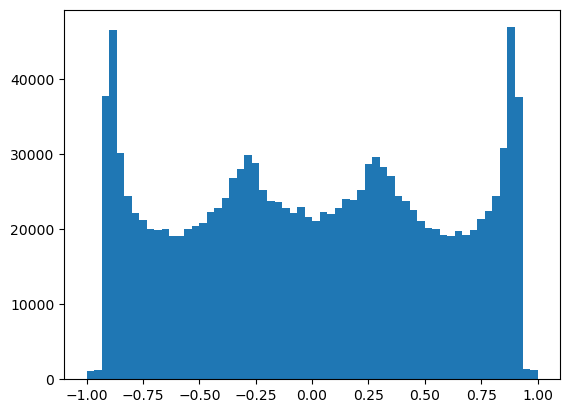

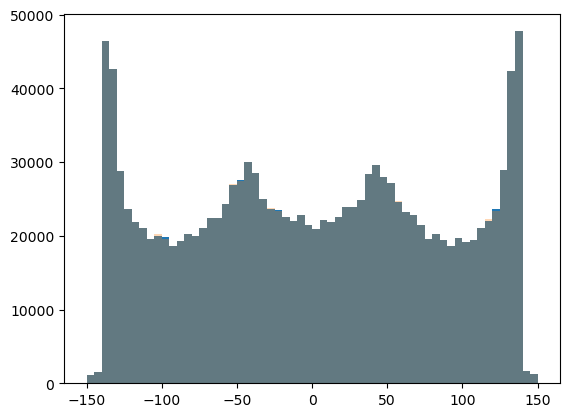

In [48]:
from sklearn.preprocessing import PowerTransformer

pipe = Pipeline(
    [
        #('box-cox', PowerTransformer()),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

orig_rng = (-150, 150)
var = df['RecoPho_x_calo'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=60);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=60, range=orig_rng);
plt.hist(old_var, bins=60, range=orig_rng, alpha=0.3);

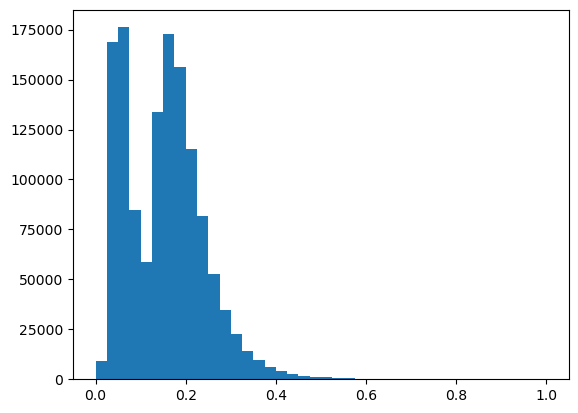

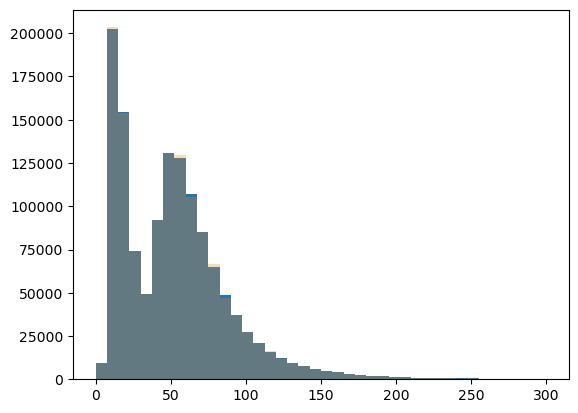

In [47]:
pipe = Pipeline(
    [
        ('log_trans', FunctionTransformer(lambda x: np.log1p(x*0.01), inverse_func=lambda x: np.expm1(x)/0.01)),
        ('scaler', MinMaxScaler((0, 1)))
    ]
)
orig_rng = (0, 300)
var = df['GenPho_pt'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

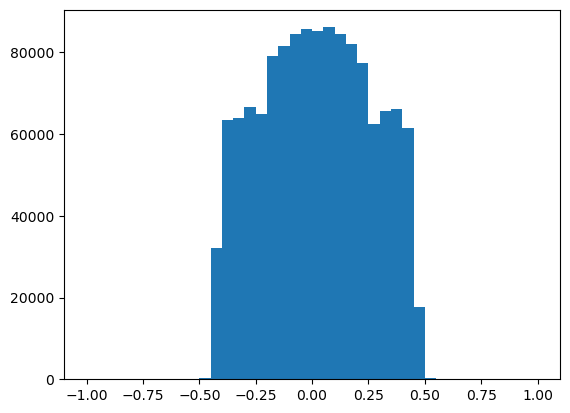

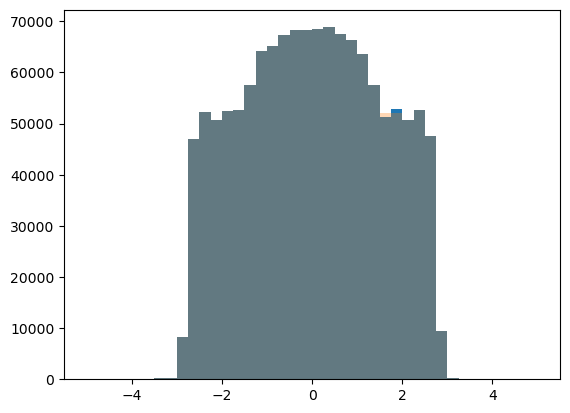

In [53]:
pipe = Pipeline(
    [
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)
orig_rng = (-5, 5)
var = df['GenPho_eta'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

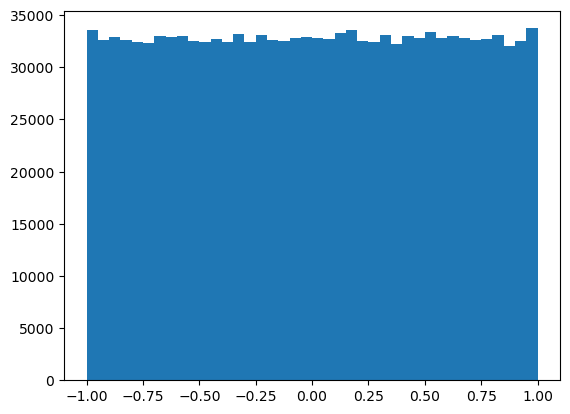

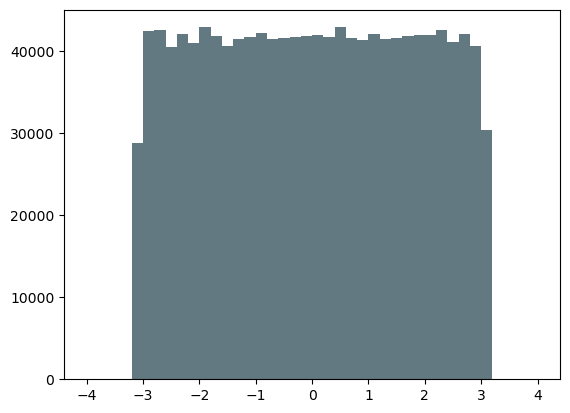

In [55]:
pipe = Pipeline(
    [
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)
orig_rng = (-4, 4)
var = df['GenPho_phi'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

[ 1 23 44]


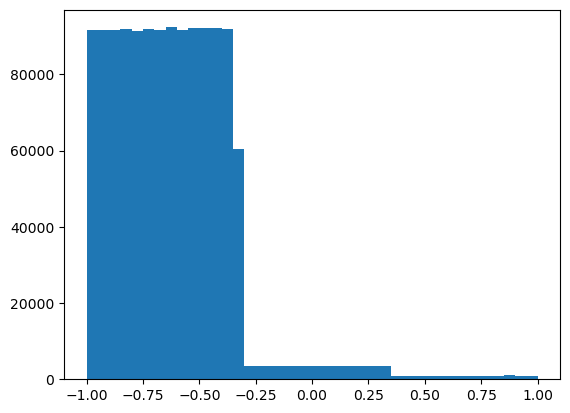

[ 1 23 44]


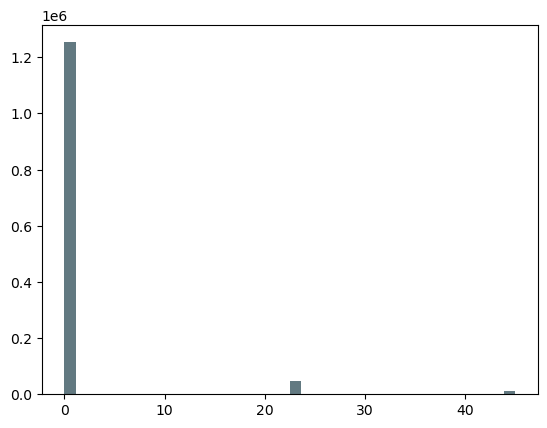

In [193]:
from sklearn.base import TransformerMixin, BaseEstimator

"""
class Smearer(TransformerMixin, BaseEstimator):
    def __init__(self, kind):
        if kind not in ['gaus', 'uniform']:
            raise ValueError
        self.kind = kind
        
    def half_distances(self, arr):
        diffs = np.diff(arr)
        half_diffs = diffs / 2
        result = np.concatenate(([arr[0] - half_diffs[0]], 
                                  arr[:-1] + half_diffs, 
                                  [arr[-1] + half_diffs[-1]]))
        return result
    
    def fit(self, X, y=None):
        self.values = np.unique(X)
        self.half_distances = half_distances(self.values)
        self.half_widths = np.array([np.abs(i - j) for i, j in zip(self.half_distances[:-1], self.half_distances[1:])])
    
    def transform(self, X, y=None):
        self.numbers = np.unique(X)
        ranges = {}
        for i, n in enumerate(self.numbers):
            if i == 0:
                half_width = abs(self.numbers[i+1] - n) / 2
                ranges[n] = [n - half_width, n + half_width]
            elif i == (len(self.numbers) - 1):
                half_width = abs(n - self.numbers[i - 1]) / 2
                ranges[n] = [n - half_width, n + half_width]
            else:
                half_width_left = abs(n - self.numbers[i - 1]) / 2
                half_width_right = abs(self.numbers[i + 1] - n) / 2
                ranges[n] = [n - half_width_left, n + half_width_right]

        return np.array([np.random.uniform(ranges[int(r)][0], ranges[int(r)][1]) for r in X]).reshape(-1, 1)
    
    def inverse_transform(self, X, y=None):
        new_arr = []
        for x in X:
            index = np.argmin(np.abs(self.numbers - x))
            new_arr.append(self.numbers[index])
        return np.array(new_arr).reshape(-1, 1)
"""

class Smearer(TransformerMixin, BaseEstimator):
    def __init__(self, kind):
        if kind not in ['gaus', 'uniform']:
            raise ValueError
        self.kind = kind
        
    def get_half_distances(self, arr):
        diffs = np.diff(arr)
        half_diffs = diffs / 2
        result = np.concatenate(([arr[0] - half_diffs[0]], 
                                  arr[:-1] + half_diffs, 
                                  [arr[-1] + half_diffs[-1]]))
        return result
    
    def count_occurrences(self, arr):
        unique_values = np.unique(arr)
        counts = np.bincount(arr[:, 0])
        return dict(zip(unique_values, counts[unique_values]))
    
    def find_closest_numbers(self, sample, numbers):
        closest_indices = np.argmin(np.abs(sample[:, 0] - numbers[:, np.newaxis]), axis=0)
        return numbers[closest_indices]
    
    def fit(self, X, y=None):
        self.occurrences = self.count_occurrences(X)
        self.values = np.array(list(self.occurrences.keys()))
        self.half_distances = self.get_half_distances(self.values) # one more item wrt occurrances, values and half_widths
        self.half_widths = np.array([np.abs(i - j) for i, j in zip(self.half_distances[:-1], self.half_distances[1:])])
        
        return self
    
    def transform(self, X, y=None):
        new_sub_arrs = []
        for idx, (number, occ) in enumerate(self.occurrences.items()):
            if self.kind == 'uniform':
                new_sub_arrs.append(np.random.uniform(low=self.half_distances[idx], high=self.half_distances[idx+1], size=occ))
            elif self.kind == 'gaus':
                scale = self.half_widths[idx] / 2
                new_sub_arrs.append(np.random.normal(loc=number, scale=scale, size=occ))
        arr = np.concatenate(new_sub_arrs).reshape(-1, 1)
        np.random.shuffle(arr)
        return arr
    
    def inverse_transform(self, X, y=None):
        return self.find_closest_numbers(X, self.values).reshape(-1, 1)


pipe = Pipeline(
    [
        ('smearer', Smearer('uniform')),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

orig_rng = (0, 45)
var = df['GenPho_status'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

In [188]:
import numpy as np

def find_closest_numbers(sample, numbers):
    print(sample.shape)
    print(numbers.shape)
    closest_indices = np.argmin(np.abs(sample - numbers[:, np.newaxis]), axis=0)
    return numbers[closest_indices]

sample = np.array([1.2, 3.5, 6.8, 9.1, 4.4, 55])
numbers = np.array([1, 4, 7, 10])
closest = find_closest_numbers(sample, numbers)

print(closest)  # Output: [1 4 7 10]


(6,)
(4,)
[ 1  4  7 10  4 10]


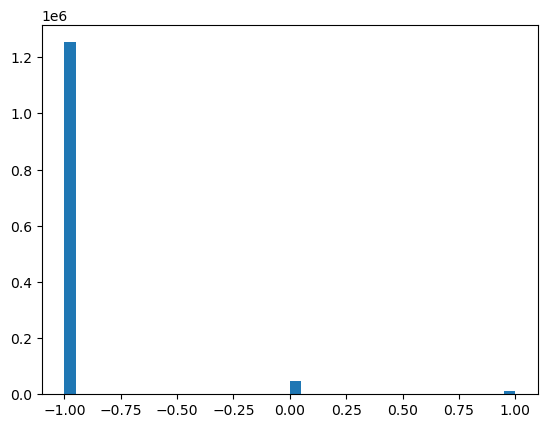

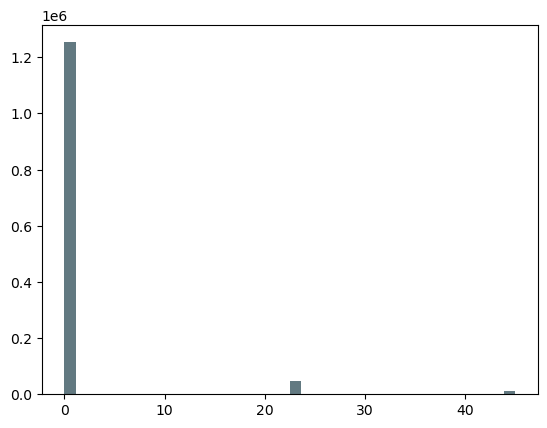

In [78]:
from scipy.ndimage.filters import uniform_filter1d

pipe = Pipeline(
    [
        ('arctan_trans', FunctionTransformer(lambda x: np.arctan(x*100), inverse_func=lambda x: (np.tan(x))/100)),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

orig_rng = (0, 45)
var = df['GenPho_status'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

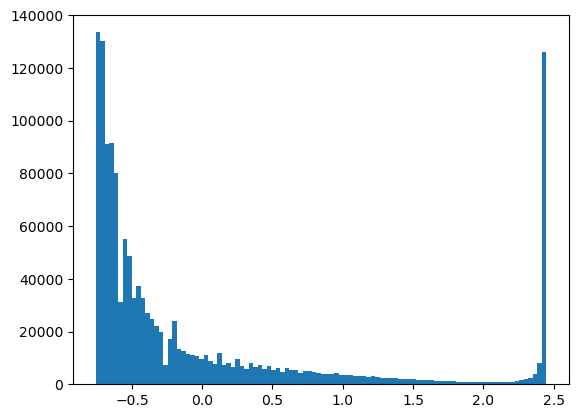

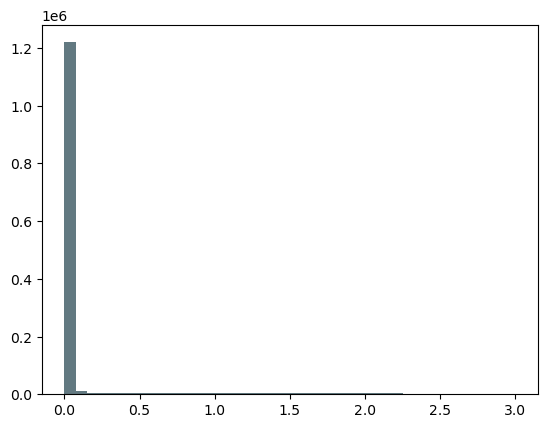

In [19]:
pipe = Pipeline(
    [
        #('arctan_trans', FunctionTransformer(lambda x: np.arctan(x*100), inverse_func=lambda x: (np.tan(x))/100)),
        #('scaler', MinMaxScaler((-1, 1)))
        #("johnson", PowerTransformer(method="yeo-johnson")),
        ("move-right", FunctionTransformer(lambda x: x + 1e-1, inverse_func=lambda x: x - 1e-1)),
        ("box-cox", PowerTransformer(method="box-cox")),
        ("standard", StandardScaler()),
    ]
)

orig_rng = (0, 3)
var = df['RecoPhoGenPho_deltaeta'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=100);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

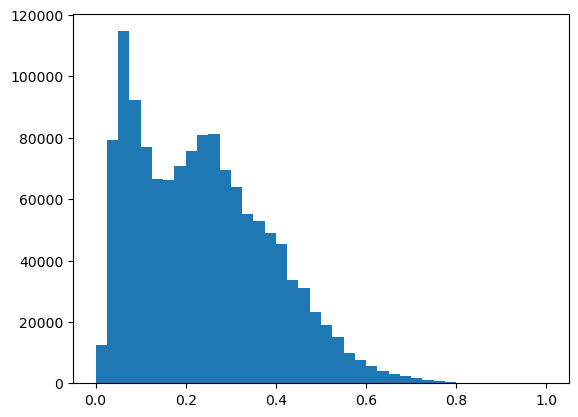

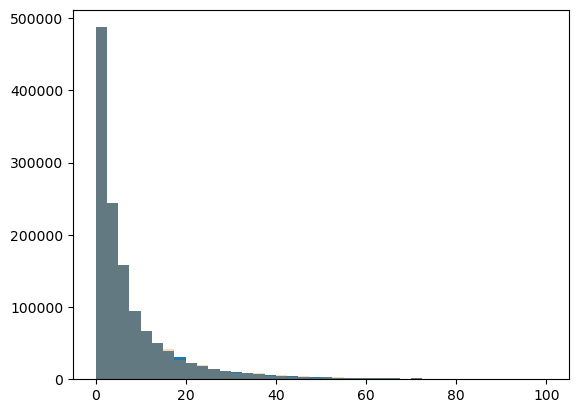

In [17]:
pipe = Pipeline(
    [
        ('log_trans', FunctionTransformer(lambda x: np.log1p(x), inverse_func=lambda x: np.expm1(x))),
        ('scaler', MinMaxScaler((0, 1)))
    ]
)

orig_rng = (0, 100)
var = df['RecoPho_energyErr'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

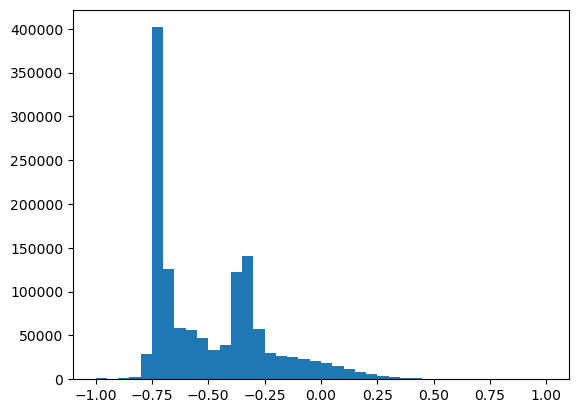

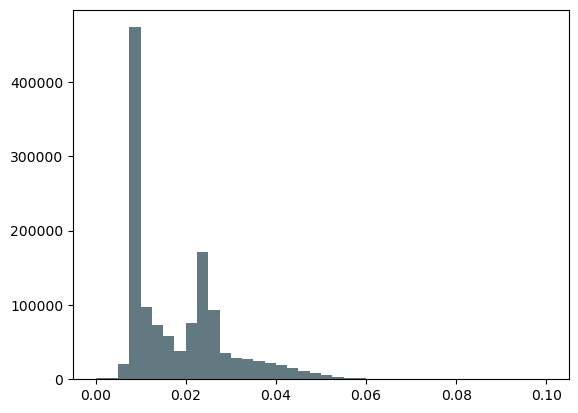

In [9]:
pipe = Pipeline(
    [
        ('log_trans', FunctionTransformer(lambda x: np.log(x*10 + 1e-1), inverse_func=lambda x: (np.exp(x) - 1e-1)/10)),
        ('arctan_trans', FunctionTransformer(lambda x: np.arctan(x - 1.25), inverse_func=lambda x: (np.tan(x) + 1.25))),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

orig_rng = (0, 0.1)
var = df['RecoPho_sieie'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

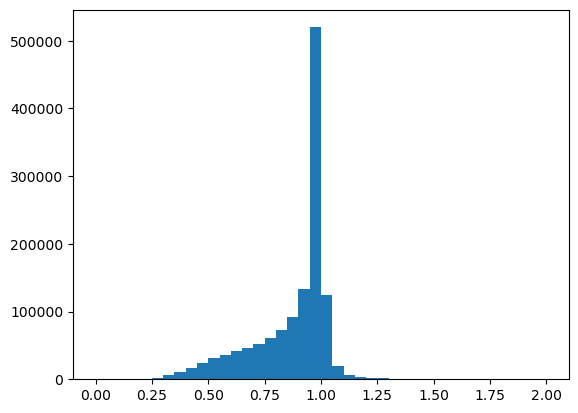

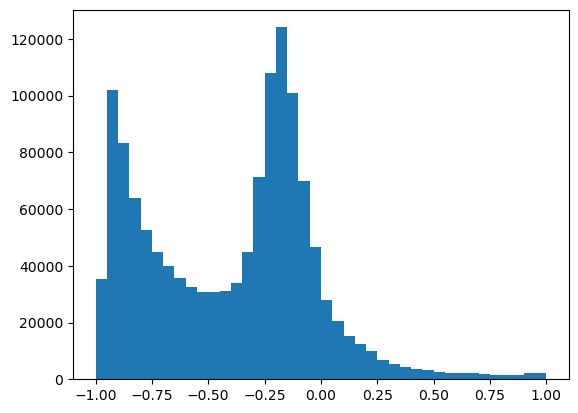

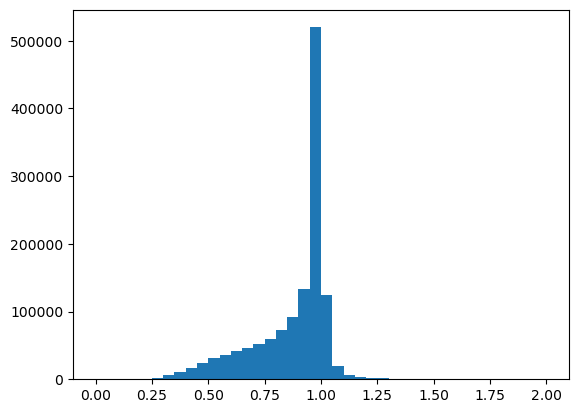

In [61]:
pipe = Pipeline(
    [
        ('log_trans', FunctionTransformer(lambda x: np.log(x + 1e-2), inverse_func=lambda x: np.exp(x) - 1e-2)),
        ('arctan_trans', FunctionTransformer(lambda x: np.arctan(x*10 - 0.15), inverse_func=lambda x: (np.tan(x) + 0.15)/10)),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

r9 = df['RecoPho_r9'].values
plt.hist(r9, bins=40, range=(0, 2));
plt.show()
new_r9 = pipe.fit_transform(r9.reshape(-1, 1))
plt.hist(new_r9, bins=40);
plt.show()
old_r9 = pipe.inverse_transform(new_r9)
plt.hist(old_r9, bins=40, range=(0, 2));

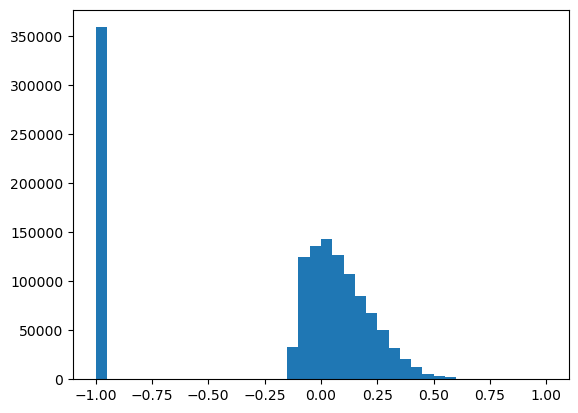

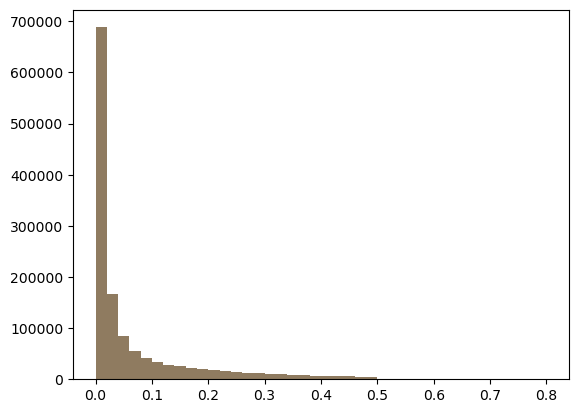

In [87]:
pipe = Pipeline(
    [
        #('log_trans', FunctionTransformer(lambda x: np.log(x + 1e-2), inverse_func=lambda x: np.exp(x) - 1e-2)),
        #('log_trans', FunctionTransformer(np.log1p, inverse_func=np.expm1)),
        #('pow', PowerTransformer()),
        ('qtgaus', QuantileTransformer(output_distribution="normal", n_quantiles=1000, random_state=0)),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

var = df['RecoPho_hoe'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40)
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(old_var, bins=40, range=(0, 0.8));
plt.hist(var, bins=40, range=(0, 0.8), alpha=0.5);

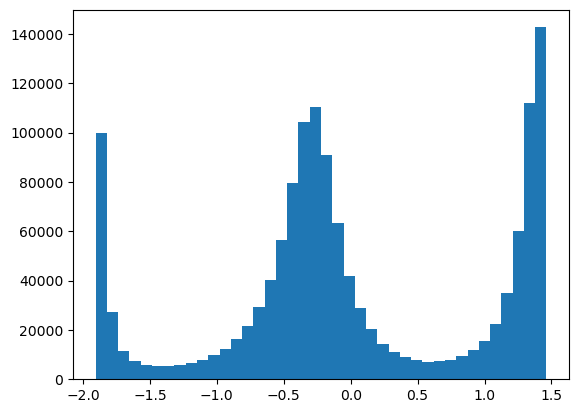

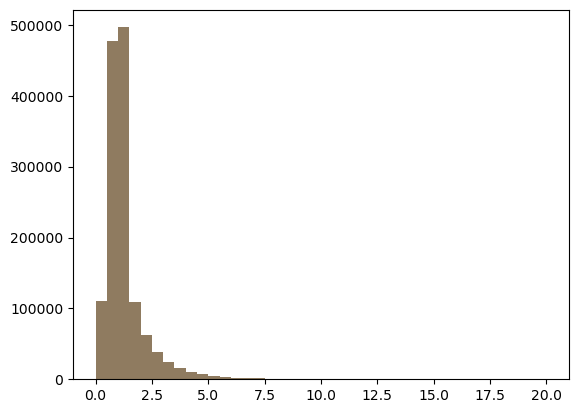

In [9]:
pipe = Pipeline(
    [
        #('log_trans', FunctionTransformer(lambda x: np.log(x + 1e-2), inverse_func=lambda x: np.exp(x) - 1e-2)),
        #('log_trans', FunctionTransformer(np.log1p, inverse_func=np.expm1)),
        ('arctan_trans', FunctionTransformer(lambda x: np.arctan(x*10 - 10), inverse_func=lambda x: (np.tan(x) + 10)/10)),
        #('scaler', MinMaxScaler((-1, 1)))
        #("box-cox", PowerTransformer(method="box-cox")),
        ("standard", StandardScaler()),
    ]
)

var = df['RecoPhoGenPho_ptratio'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40)
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(old_var, bins=40, range=(0, 20));
plt.hist(var, bins=40, range=(0, 20), alpha=0.5);